<a href="https://colab.research.google.com/github/myozaw5288/git/blob/master/lab3(MMO).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
%matplotlib inline
sns.set(style="ticks")

In [ ]:
data_loaded = pd.read_csv('solar.csv', sep=",")

In [ ]:
data_loaded.head()

,Catalog Number,Unnamed: 1,Time,Delta,Lunationnumber,Sarosnumber,Unnamed: 6,Gamma,Eclipsemagnitude,Unnamed: 9,Unnamed: 10,Sunaltitude,Sunazimuth,PathWidth (km),Central Duration,UNIXTime,WindDirection(Degrees),TimeSunRise,TimeSunSet
0,1.0,NaN,3:14:51,46438.0,49456.0,5.0,NaN,0.2701,1.0733,NaN,NaN,74.0,344.0,247.0,0:06:37,1475229326,177.39,6:13:00,18:13:00
1,2.0,NaN,23:45:23,46426.0,49457.0,10.0,NaN,0.2702,0.9382,NaN,NaN,76.0,21.0,248.0,0:06:38,1475229023,176.78,6:13:00,18:13:00
2,3.0,NaN,18:09:16,46415.0,49458.0,15.0,NaN,0.2703,1.0284,NaN,NaN,60.0,151.0,249.0,0:06:37,1475228726,158.75,6:13:00,18:13:00
3,4.0,NaN,5:57:03,46403.0,49459.0,20.0,NaN,0.2704,0.9806,NaN,NaN,25.0,74.0,250.0,0:06:37,1475228421,137.71,6:13:00,18:13:00
4,5.0,NaN,13:19:56,46393.0,49460.0,-13.0,NaN,0.2705,0.1611,NaN,NaN,0.0,281.0,251.0,0:06:38,1475228124,104.95,6:13:00,18:13:00


In [ ]:
data_loaded.shape

(32686, 19)

In [ ]:
data_features = list(zip(
[i for i in data_loaded.columns],
zip(
    #типы колонок
    [str(i) for i in data_loaded.dtypes],
    #проверка, есть ли пропущенные значения
    [i for i in data_loaded.isnull().sum()]
)))
data_features

[('Catalog Number', ('float64', 20788)),
 ('Unnamed: 1', ('float64', 32686)),
 ('Time', ('object', 20788)),
 ('Delta', ('float64', 20788)),
 ('Lunationnumber', ('float64', 20788)),
 ('Sarosnumber', ('float64', 20788)),
 ('Unnamed: 6', ('float64', 32686)),
 ('Gamma', ('float64', 20788)),
 ('Eclipsemagnitude', ('float64', 20788)),
 ('Unnamed: 9', ('float64', 32686)),
 ('Unnamed: 10', ('float64', 32686)),
 ('Sunaltitude', ('float64', 20788)),
 ('Sunazimuth', ('float64', 20788)),
 ('PathWidth (km)', ('float64', 20835)),
 ('Central Duration', ('object', 19672)),
 ('UNIXTime', ('int64', 0)),
 ('WindDirection(Degrees)', ('float64', 0)),
 ('TimeSunRise', ('object', 0)),
 ('TimeSunSet', ('object', 0))]

In [ ]:
cols_with_na = ['Time',	'Delta',	'Lunationnumber',	'Sarosnumber'	,'Unnamed: 6']
data_drop = data_loaded[cols_with_na].dropna()
data_drop.shape

(0, 5)

In [ ]:
def plot_hist_diff(old_ds, new_ds, cols):
    """
    Разница между распределениями до и после устранения пропусков
    """
    for c in cols:   
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.title.set_text('Поле - ' + str(c))
        old_ds[c].hist(bins=50, ax=ax, density=True, color='green')
        new_ds[c].hist(bins=50, ax=ax, color='blue', density=True, alpha=0.5)
        plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


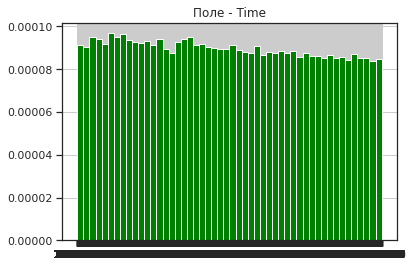

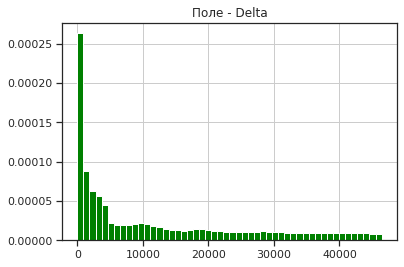

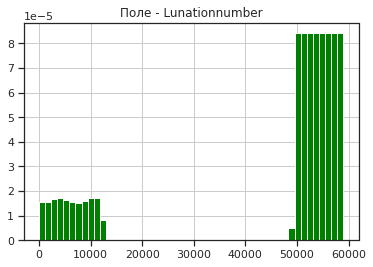

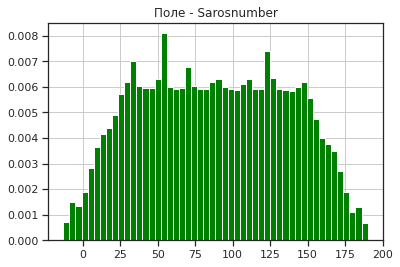

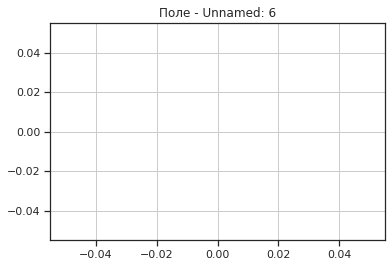

In [ ]:
plot_hist_diff(data_loaded, data_drop, cols_with_na)

In [ ]:
def impute_column(dataset, column, strategy_param, fill_value_param=None):
    """
    Заполнение пропусков в одном признаке
    """
    temp_data = dataset[[column]].values
    size = temp_data.shape[0]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imputer = SimpleImputer(strategy=strategy_param, 
                            fill_value=fill_value_param)
    all_data = imputer.fit_transform(temp_data)
    
    missed_data = temp_data[mask_missing_values_only]
    filled_data = all_data[mask_missing_values_only]
    
    return all_data.reshape((size,)), filled_data, missed_data

In [ ]:
#Заполнение показателем центра распределения
all_data, filled_data, missed_data = impute_column(data_loaded, 'Delta', 'mean')
all_data

array([46438.        , 46426.        , 46415.        , ...,
       12142.17280215, 12142.17280215, 12142.17280215])

In [ ]:
data_loaded['Delta']

0        46438.0
1        46426.0
2        46415.0
3        46403.0
4        46393.0
          ...   
32681        NaN
32682        NaN
32683        NaN
32684        NaN
32685        NaN
Name: Delta, Length: 32686, dtype: float64

In [ ]:
def research_impute_numeric_column(dataset, num_column, const_value=None):
    strategy_params = ['mean', 'median', 'most_frequent', 'constant']
    strategy_params_names = ['Среднее', 'Медиана', 'Мода']
    strategy_params_names.append('Константа = ' + str(const_value))
    
    original_temp_data = dataset[[num_column]].values
    size = original_temp_data.shape[0]
    original_data = original_temp_data.reshape((size,))
    
    new_df = pd.DataFrame({'Исходные данные':original_data})
       
    for i in range(len(strategy_params)):
        strategy = strategy_params[i]
        col_name = strategy_params_names[i]
        if (strategy!='constant') or (strategy == 'constant' and const_value!=None):
            if strategy == 'constant':
                temp_data, _, _ = impute_column(dataset, num_column, strategy, fill_value_param=const_value)
            else:
                temp_data, _, _ = impute_column(dataset, num_column, strategy)
            new_df[col_name] = temp_data
        
    sns.kdeplot(data=new_df)

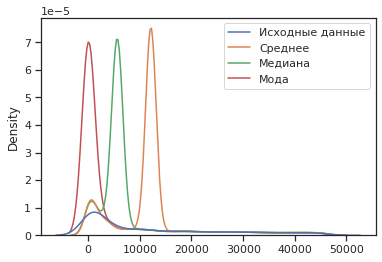

In [ ]:
#Сравнение заполнения различными показателями распределения
research_impute_numeric_column(data_loaded, 'Delta')

In [ ]:
#Заполнение наиболее распросттраненным значением категории
data_cat_cols = ['Delta','Gamma',	'Sarosnumber']
data_cat_new = data_loaded[data_cat_cols].copy()

In [ ]:
data_loaded.loc[data_loaded.loc[:, 'Delta'] == 'Новозыбков']

,Catalog Number,Unnamed: 1,Time,Delta,Lunationnumber,Sarosnumber,Unnamed: 6,Gamma,Eclipsemagnitude,Unnamed: 9,Unnamed: 10,Sunaltitude,Sunazimuth,PathWidth (km),Central Duration,UNIXTime,WindDirection(Degrees),TimeSunRise,TimeSunSet


In [ ]:
Delta_cat_new, _, _ = impute_column(data_cat_new, 'Delta', 'most_frequent')
Gamma_cat_new, _, _ = impute_column(data_cat_new, 'Gamma', 'most_frequent')
Sarosnumber_cat_new, _, _ = impute_column(data_cat_new, 'Sarosnumber', 'most_frequent')

In [ ]:
data_cat_new['Delta'] = Delta_cat_new
data_cat_new['Gamma'] = Gamma_cat_new
data_cat_new['Sarosnumber'] = Sarosnumber_cat_new

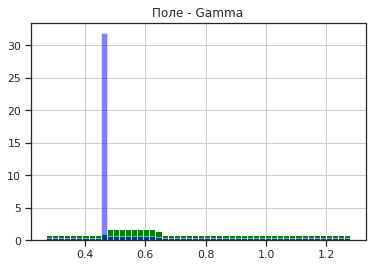

In [ ]:
plot_hist_diff(data_loaded, data_cat_new, ['Gamma'])

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
data = data_loaded.copy()
data['Gamma']

0        0.2701
1        0.2702
2        0.2703
3        0.2704
4        0.2705
          ...  
32681       NaN
32682       NaN
32683       NaN
32684       NaN
32685       NaN
Name: Gamma, Length: 32686, dtype: float64

In [ ]:
data['Gamma'] = data_cat_new['Gamma']
data['Gamma']

0        0.2701
1        0.2702
2        0.2703
3        0.2704
4        0.2705
          ...  
32681    0.4686
32682    0.4686
32683    0.4686
32684    0.4686
32685    0.4686
Name: Gamma, Length: 32686, dtype: float64

In [ ]:
data_loaded['Gamma']

0        0.2701
1        0.2702
2        0.2703
3        0.2704
4        0.2705
          ...  
32681       NaN
32682       NaN
32683       NaN
32684       NaN
32685       NaN
Name: Gamma, Length: 32686, dtype: float64

In [ ]:
le = LabelEncoder()
cat_enc_le = le.fit_transform(data['Gamma'])
cat_enc_le

array([   0,    1,    2, ..., 1985, 1985, 1985])

In [ ]:
data['Gamma'].unique()

array([0.2701, 0.2702, 0.2703, ..., 1.2792, 1.2793, 1.2794])

In [ ]:
np.unique(cat_enc_le)

array([    0,     1,     2, ..., 10091, 10092, 10093])

**2. One-Hot Encoding**

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:

ohe = OneHotEncoder()
cat_enc_ohe = ohe.fit_transform(data[['Gamma']])
cat_enc_ohe

<32686x10094 sparse matrix of type '<class 'numpy.float64'>'
	with 32686 stored elements in Compressed Sparse Row format>

In [ ]:
cat_enc_ohe.todense()[0:10]

matrix([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# one-hot encoding с помощью pd.get_dummies()
pd.get_dummies(data[['Gamma']]).head()

,Gamma
0,0.2701
1,0.2702
2,0.2703
3,0.2704
4,0.2705



**Нормализация числовых признаков**

In [ ]:
import scipy.stats as stats

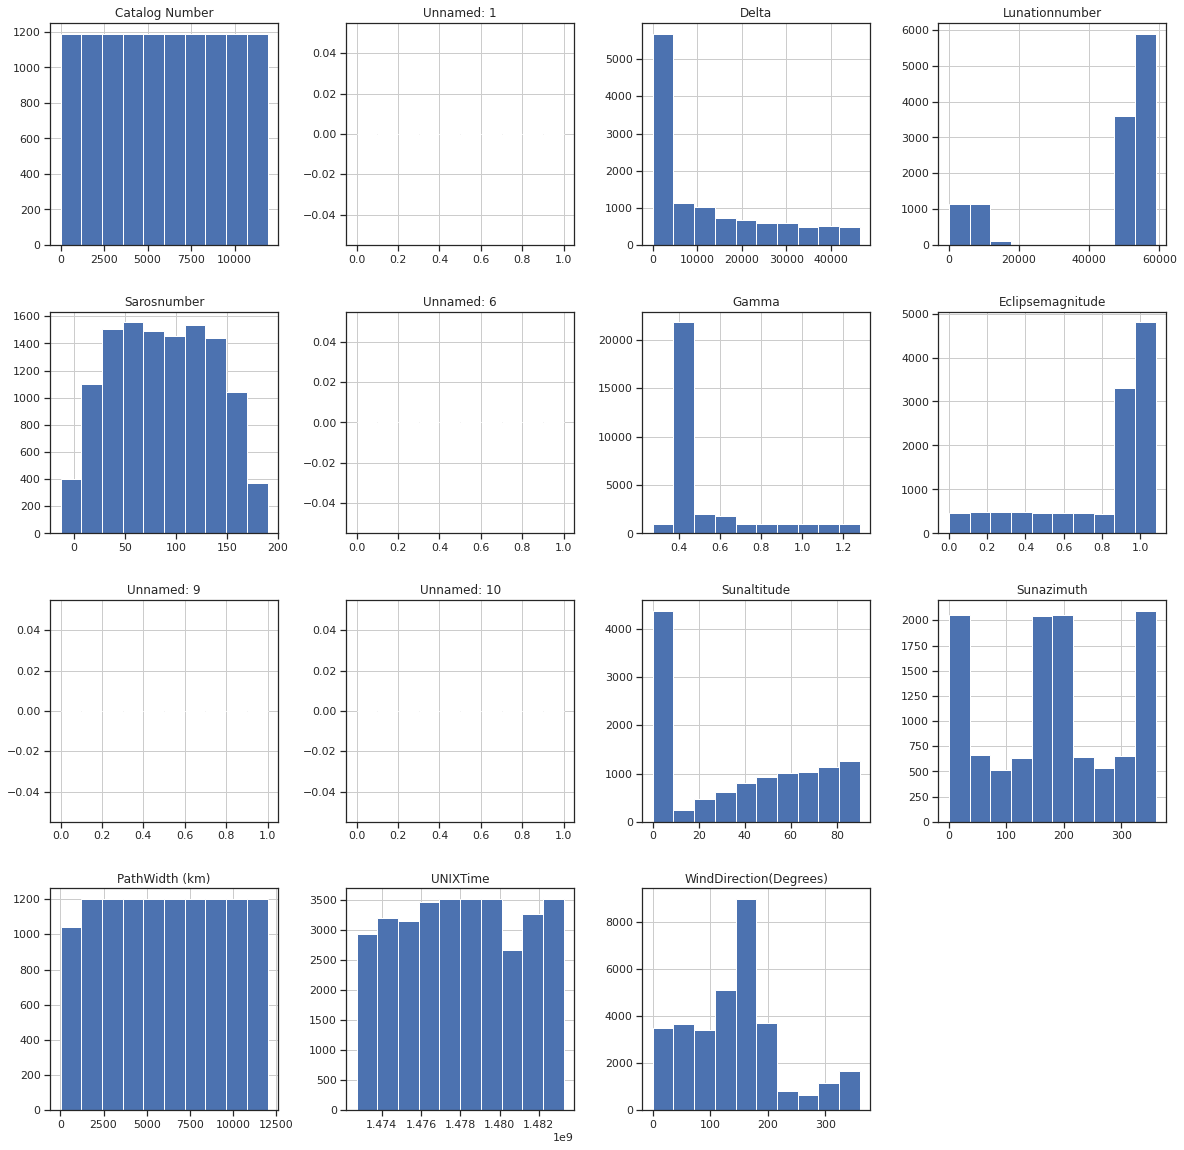

In [ ]:
data.hist(figsize=(20,20))
plt.show()

In [ ]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,6))
    # гистограмма
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

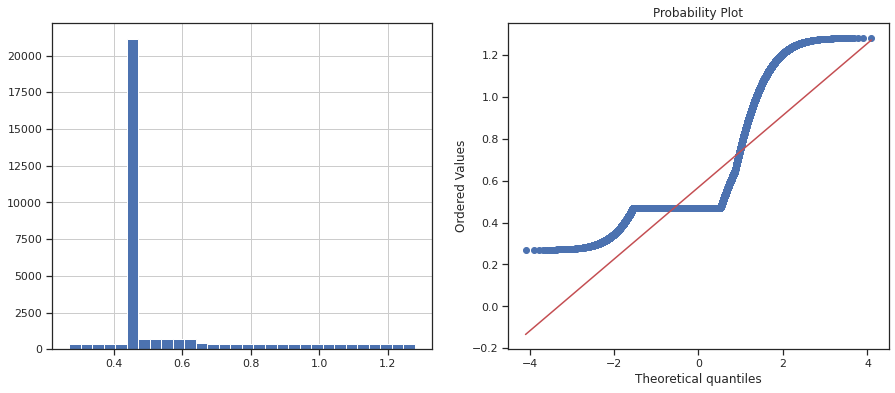

In [ ]:
diagnostic_plots(data, 'Gamma')

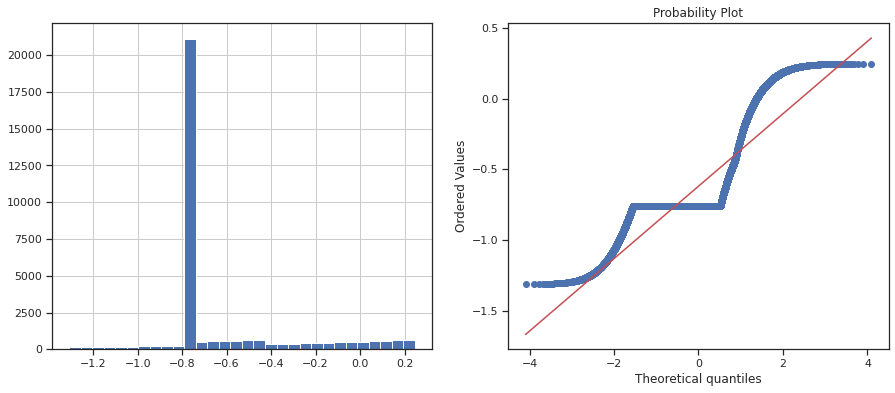

In [ ]:
data['Gamma_log'] = np.log(data['Gamma'])
diagnostic_plots(data, 'Gamma_log')

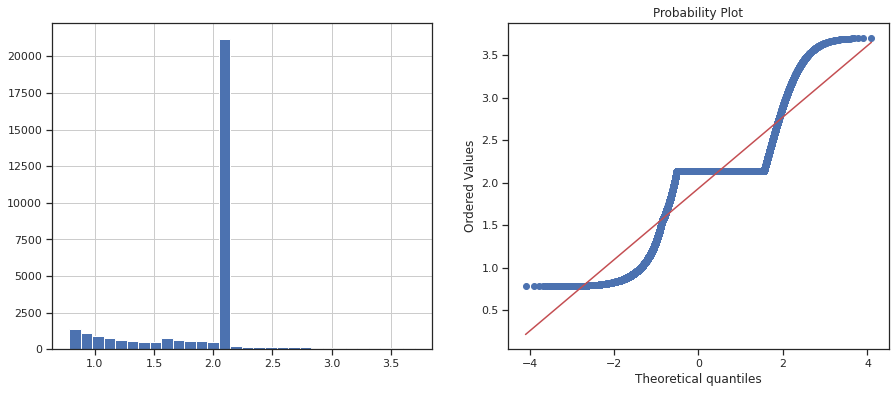

In [ ]:
data['Gamma_reciprocal'] = 1 / (data['Gamma']) 
diagnostic_plots(data, 'Gamma_reciprocal')

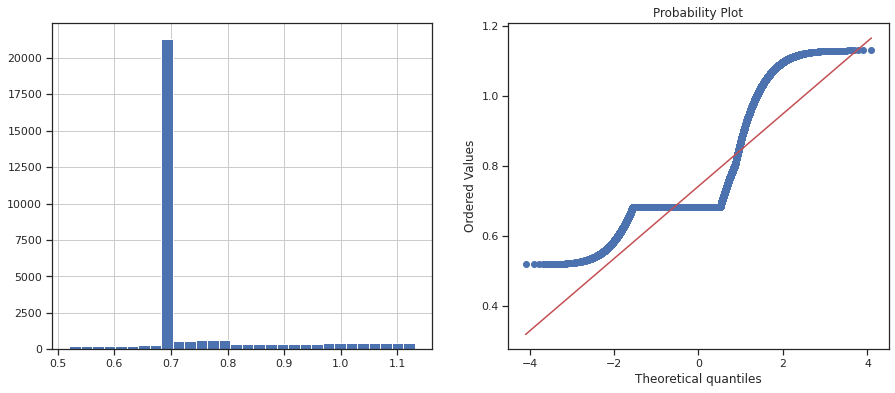

In [ ]:
data['Gamma_sqr'] = data['Gamma']**(1/2) 
diagnostic_plots(data, 'Gamma_sqr')

Оптимальное значение λ = -1.597211394590668


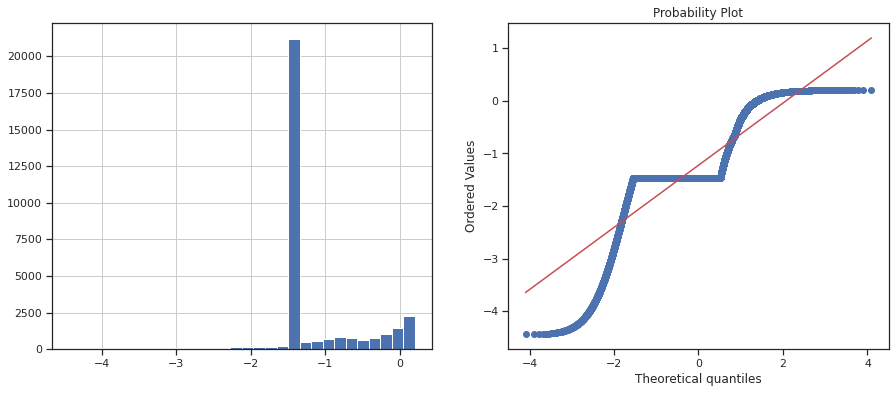

In [ ]:
data['Gamma_boxcox'], param = stats.boxcox(data['Gamma']) 
print('Оптимальное значение λ = {}'.format(param))
diagnostic_plots(data, 'Gamma_boxcox')

Оптимальное значение λ = -6.335929584796748


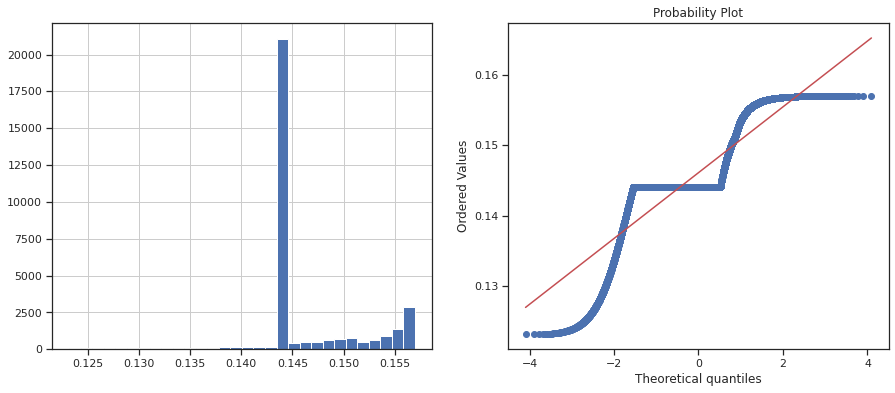

In [ ]:
# Необходимо преобразовать данные к действительному типу
data['Gamma'] = data['Gamma'].astype('float')
data['Gamma_yeojohnson'], param = stats.yeojohnson(data['Gamma']) 
print('Оптимальное значение λ = {}'.format(param))
diagnostic_plots(data, 'Gamma_yeojohnson')

**Масштабирование признаков**

**На основе Z-оценки*

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler

In [ ]:
cols_to_scale = ['Delta',	'Gamma','Lunationnumber',	'Sarosnumber']
data_to_scale = data_loaded[cols_to_scale]
data_to_scale = data_to_scale.dropna()
data_to_scale.describe()

,Delta,Gamma,Lunationnumber,Sarosnumber
count,11898.000000,11898.000000,11898.000000,11898.000000
mean,12142.172802,0.742000,44567.074971,87.483190
std,13583.402888,0.280094,19443.399140,48.380284
min,-6.000000,0.270100,1.000000,-13.000000
25%,970.250000,0.518025,50038.250000,47.000000
50%,5636.500000,0.684550,53012.500000,87.000000
75%,20943.500000,0.981975,55986.750000,128.000000
max,46438.000000,1.279400,58961.000000,190.000000


In [ ]:
X_ALL = data_to_scale.drop('Gamma', axis=1)
X_ALL

,Delta,Lunationnumber,Sarosnumber
0,46438.0,49456.0,5.0
1,46426.0,49457.0,10.0
2,46415.0,49458.0,15.0
3,46403.0,49459.0,20.0
4,46393.0,49460.0,-13.0
...,...,...,...
11893,4414.0,12355.0,187.0
11894,4417.0,12360.0,154.0
11895,4420.0,12366.0,159.0
11896,4424.0,12372.0,164.0


In [ ]:
# Функция восстановления датафрейма на основе масштабированных данных 
def arr_to_df(arr_scaled):
    res = pd.DataFrame(arr_scaled, columns=X_ALL.columns)
    return res

In [ ]:
# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X_ALL, data_to_scale['Gamma'],
                                                    test_size=0.2,
                                                    random_state=1)
# Преобразуем массивы в DataFrame
X_train_df = arr_to_df(X_train)
X_test_df = arr_to_df(X_test)

X_train_df.shape, X_test_df.shape

((9518, 3), (2380, 3))

In [ ]:
# Обучаем StandardScaler на всей выборке и масштабируем
cs11 = StandardScaler()
data_cs11_scaled_temp = cs11.fit_transform(X_ALL)
# формируем DataFrame на основе массива
data_cs11_scaled =  arr_to_df(data_cs11_scaled_temp)
data_cs11_scaled

,Delta,Lunationnumber,Sarosnumber
0,2.524939,0.251455,-1.704964
1,2.524056,0.251506,-1.601612
2,2.523246,0.251557,-1.498260
3,2.522363,0.251609,-1.394908
4,2.521626,0.251660,-2.077032
...,...,...,...
11893,-0.568966,-1.656780,2.057057
11894,-0.568745,-1.656523,1.374932
11895,-0.568525,-1.656214,1.478284
11896,-0.568230,-1.655905,1.581637


In [ ]:
# Построение плотности распределения
def draw_kde(col_list, df1, df2, label1, label2):
    fig, (ax1, ax2) = plt.subplots(
        ncols=2, figsize=(12, 5))
    # первый график
    ax1.set_title(label1)
    sns.kdeplot(data=df1[col_list], ax=ax1)
    # второй график
    ax2.set_title(label2)
    sns.kdeplot(data=df2[col_list], ax=ax2)
    plt.show()

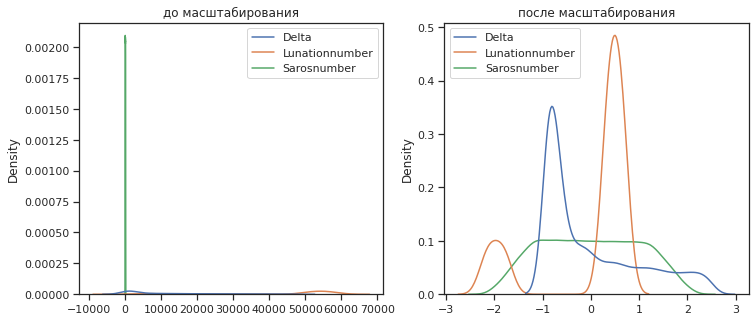

In [ ]:
draw_kde(['Delta', 'Lunationnumber', 'Sarosnumber'], data_to_scale, data_cs11_scaled,
         'до масштабирования', 'после масштабирования')

In [ ]:
# Обучаем StandardScaler на обучающей выборке 
# и масштабируем обучающую и тестовую выборки
cs12 = StandardScaler()
cs12.fit(X_train)
data_cs12_scaled_train_temp = cs12.transform(X_train)
data_cs12_scaled_test_temp = cs12.transform(X_test)
# формируем DataFrame на основе массива
data_cs12_scaled_train = arr_to_df(data_cs12_scaled_train_temp)
data_cs12_scaled_test = arr_to_df(data_cs12_scaled_test_temp)

In [ ]:
data_cs12_scaled_train.describe()

,Delta,Lunationnumber,Sarosnumber
count,9.518000e+03,9.518000e+03,9.518000e+03
mean,6.270812e-17,1.524370e-16,2.664162e-17
std,1.000053e+00,1.000053e+00,1.000053e+00
min,-8.910189e-01,-2.283891e+00,-2.084793e+00
25%,-8.192373e-01,2.833294e-01,-8.227633e-01
50%,-4.855315e-01,4.361728e-01,-5.547213e-03
75%,6.424649e-01,5.894395e-01,8.323579e-01
max,2.541490e+00,7.411670e-01,2.115077e+00


In [ ]:
data_cs12_scaled_test.describe()

,Delta,Lunationnumber,Sarosnumber
count,2380.000000,2380.000000,2380.000000
mean,0.034038,0.013290,-0.029470
std,1.018901,0.987776,1.004348
min,-0.891019,-2.283327,-2.084793
25%,-0.817223,0.283432,-0.884830
50%,-0.419792,0.433684,-0.015892
75%,0.697433,0.585771,0.811669
max,2.538164,0.740911,2.073699


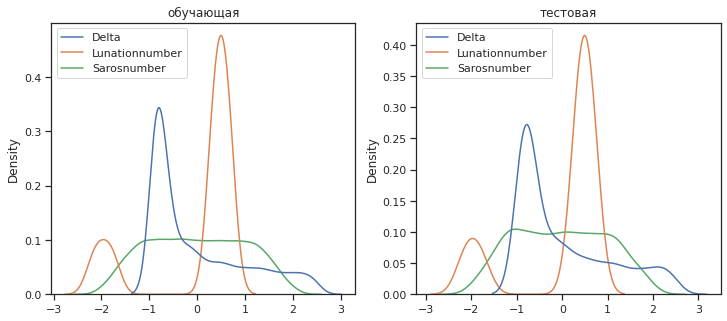

In [ ]:
# распределения для обучающей и тестовой выборки немного отличаются
draw_kde(['Delta', 'Lunationnumber', 'Sarosnumber'], data_cs12_scaled_train, data_cs12_scaled_test, 
         'обучающая', 'тестовая')


**Масштабирование "Mean Normalisation"**

In [ ]:
class MeanNormalisation:
    
    def fit(self, param_df):
        self.means = X_train.mean(axis=0)
        maxs = X_train.max(axis=0)
        mins = X_train.min(axis=0)
        self.ranges = maxs - mins

    def transform(self, param_df):
        param_df_scaled = (param_df - self.means) / self.ranges
        return param_df_scaled
    
    def fit_transform(self, param_df):
        self.fit(param_df)
        return self.transform(param_df)

In [ ]:
sc21 = MeanNormalisation()
data_cs21_scaled = sc21.fit_transform(X_ALL)
data_cs21_scaled.describe()

,Delta,Lunationnumber,Sarosnumber
count,11898.000000,11898.000000,11898.000000
mean,0.001984,0.000879,-0.001404
std,0.292468,0.329773,0.238327
min,-0.259582,-0.754991,-0.496395
25%,-0.238562,0.093674,-0.200828
50%,-0.138092,0.144119,-0.003784
75%,0.191488,0.194564,0.198187
max,0.740418,0.245009,0.503605


In [ ]:
cs22 = MeanNormalisation()
cs22.fit(X_train)
data_cs22_scaled_train = cs22.transform(X_train)
data_cs22_scaled_test = cs22.transform(X_test)

In [ ]:
data_cs22_scaled_train.describe()

,Delta,Lunationnumber,Sarosnumber
count,9.518000e+03,9.518000e+03,9.518000e+03
mean,1.947964e-17,4.507729e-17,8.934974e-18
std,2.913474e-01,3.305895e-01,2.381151e-01
min,-2.595824e-01,-7.549908e-01,-4.963947e-01
25%,-2.386701e-01,9.366079e-02,-1.959021e-01
50%,-1.414509e-01,1.441866e-01,-1.320806e-03
75%,1.871707e-01,1.948523e-01,1.981866e-01
max,7.404176e-01,2.450092e-01,5.036053e-01


In [ ]:
data_cs22_scaled_test.describe()

,Delta,Lunationnumber,Sarosnumber
count,2380.000000,2380.000000,2380.000000
mean,0.009916,0.004393,-0.007017
std,0.296839,0.326531,0.239138
min,-0.259582,-0.754804,-0.496395
25%,-0.238083,0.093695,-0.210680
50%,-0.122299,0.143364,-0.003784
75%,0.203185,0.193640,0.193260
max,0.739449,0.244924,0.493753


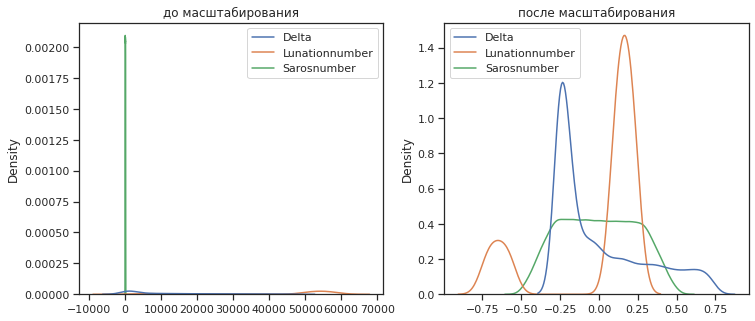

In [ ]:
draw_kde(['Delta', 'Lunationnumber', 'Sarosnumber'], data_to_scale, data_cs21_scaled, 
         'до масштабирования', 'после масштабирования')

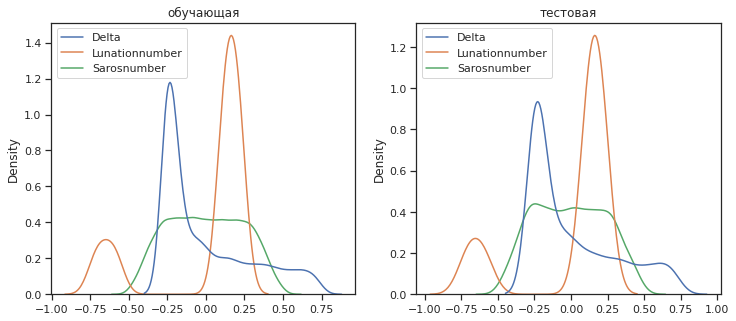

In [ ]:
draw_kde(['Delta', 'Lunationnumber', 'Sarosnumber'], data_cs22_scaled_train, data_cs22_scaled_test, 
         'обучающая', 'тестовая')

**Min-Max Масштабирование**

In [ ]:
# Обучаем StandardScaler на всей выборке и масштабируем
cs31 = MinMaxScaler()
data_cs31_scaled_temp = cs31.fit_transform(X_ALL)
# формируем DataFrame на основе массива
data_cs31_scaled = arr_to_df(data_cs31_scaled_temp)
data_cs31_scaled.describe()

,Delta,Lunationnumber,Sarosnumber
count,11898.000000,11898.000000,11898.000000
mean,0.261566,0.755870,0.494991
std,0.292468,0.329773,0.238327
min,0.000000,0.000000,0.000000
25%,0.021020,0.848664,0.295567
50%,0.121490,0.899110,0.492611
75%,0.451070,0.949555,0.694581
max,1.000000,1.000000,1.000000


In [ ]:
cs32 = MinMaxScaler()
cs32.fit(X_train)
data_cs32_scaled_train_temp = cs32.transform(X_train)
data_cs32_scaled_test_temp = cs32.transform(X_test)
# формируем DataFrame на основе массива
data_cs32_scaled_train = arr_to_df(data_cs32_scaled_train_temp)
data_cs32_scaled_test = arr_to_df(data_cs32_scaled_test_temp)

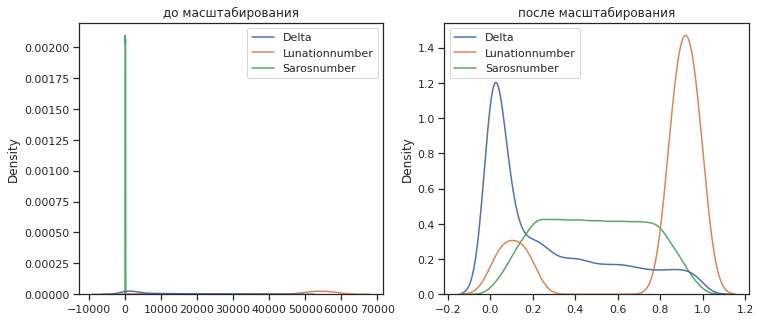

In [ ]:
draw_kde(['Delta', 'Lunationnumber', 'Sarosnumber'], data_to_scale, data_cs31_scaled,
         'до масштабирования', 'после масштабирования')

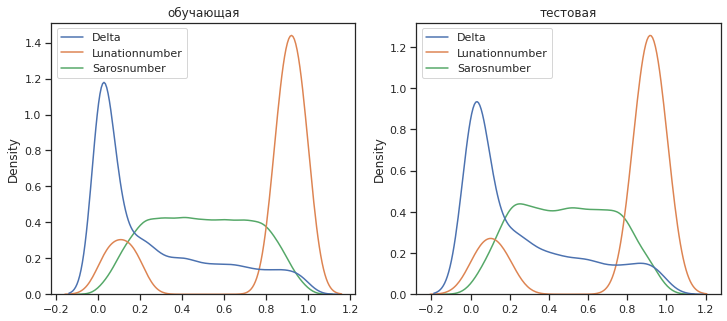

In [ ]:
draw_kde(['Delta', 'Lunationnumber', 'Sarosnumber'], data_cs32_scaled_train, data_cs32_scaled_test, 'обучающая', 'тестовая')

**Масштабирование по медиане**

In [ ]:
cs41 = RobustScaler()
data_cs41_scaled_temp = cs41.fit_transform(X_ALL)
# формируем DataFrame на основе массива
data_cs41_scaled = arr_to_df(data_cs41_scaled_temp)
data_cs41_scaled.describe()

,Delta,Lunationnumber,Sarosnumber
count,11898.000000,11898.000000,11898.000000
mean,0.325719,-1.419757,0.005965
std,0.680080,3.268622,0.597287
min,-0.282503,-8.911742,-1.234568
25%,-0.233625,-0.500000,-0.493827
50%,0.000000,0.000000,0.000000
75%,0.766375,0.500000,0.506173
max,2.042807,1.000000,1.271605


In [ ]:
cs42 = RobustScaler()
cs42.fit(X_train)
data_cs42_scaled_train_temp = cs42.transform(X_train)
data_cs42_scaled_test_temp = cs42.transform(X_test)
# формируем DataFrame на основе массива
data_cs42_scaled_train = arr_to_df(data_cs42_scaled_train_temp)
data_cs42_scaled_test = arr_to_df(data_cs42_scaled_test_temp)

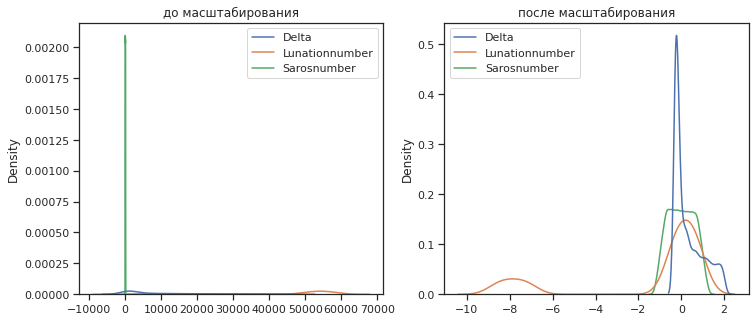

In [ ]:
draw_kde(['Delta', 'Lunationnumber', 'Sarosnumber'], data_to_scale, data_cs41_scaled,
         'до масштабирования', 'после масштабирования')

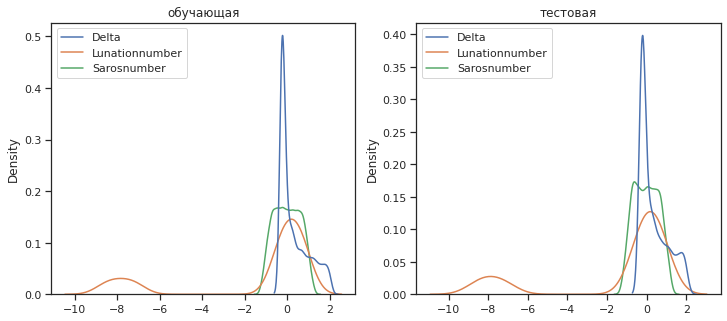

In [ ]:
draw_kde(['Delta', 'Lunationnumber', 'Sarosnumber'], data_cs42_scaled_train, data_cs42_scaled_test, 'обучающая', 'тестовая')

**Масштабирование по максимальному значению**

In [ ]:
cs51 = MaxAbsScaler()
data_cs51_scaled_temp = cs51.fit_transform(X_ALL)
# формируем DataFrame на основе массива
data_cs51_scaled = arr_to_df(data_cs51_scaled_temp)
data_cs51_scaled.describe()

,Delta,Lunationnumber,Sarosnumber
count,11898.000000,11898.000000,11898.000000
mean,0.261471,0.755874,0.460438
std,0.292506,0.329767,0.254633
min,-0.000129,0.000017,-0.068421
25%,0.020893,0.848667,0.247368
50%,0.121377,0.899111,0.457895
75%,0.450999,0.949556,0.673684
max,1.000000,1.000000,1.000000


In [ ]:
cs52_mas = MaxAbsScaler()
cs52_mean = StandardScaler(with_mean=True, with_std=False)

cs52_mas.fit(X_train)
cs52_mean.fit(X_train)

data_cs52_scaled_train_temp = cs52_mas.transform(cs52_mean.transform(X_train))
data_cs52_scaled_test_temp = cs52_mas.transform(cs52_mean.transform(X_test))
# формируем DataFrame на основе массива
data_cs52_scaled_train = arr_to_df(data_cs52_scaled_train_temp)
data_cs52_scaled_test = arr_to_df(data_cs52_scaled_test_temp)

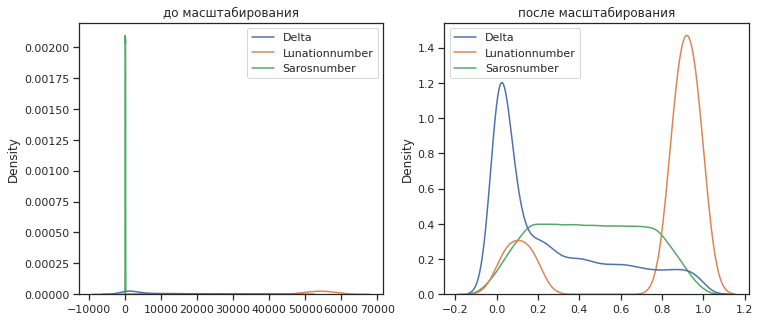

In [ ]:
draw_kde(['Delta', 'Lunationnumber', 'Sarosnumber'], data_to_scale, data_cs51_scaled, 
         'до масштабирования', 'после масштабирования')

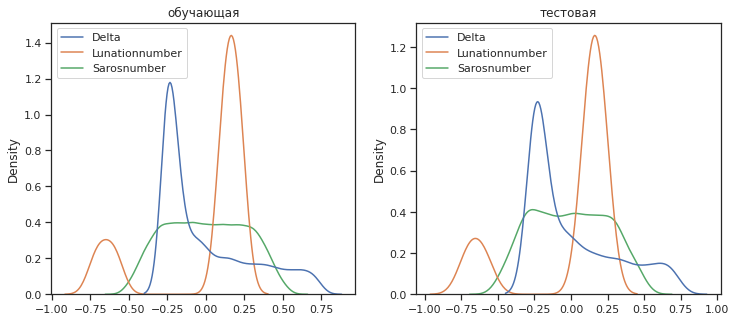

In [ ]:
draw_kde(['Delta', 'Lunationnumber', 'Sarosnumber'], data_cs52_scaled_train, data_cs52_scaled_test, 'обучающая', 'тестовая')

**Обучение моделей с различными вариантами масштабирования признаков**

In [ ]:

class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [ ]:
clas_models_dict = {'LinR': LinearRegression(), 
                    'SVR': SVR(),
                    'KNN_5':KNeighborsRegressor(n_neighbors=5),
                    'Tree':DecisionTreeRegressor(random_state=1),
                    'GB': GradientBoostingRegressor(random_state=1),
                    'RF':RandomForestRegressor(n_estimators=50, random_state=1)}

In [ ]:

X_data_dict = {'Original': (X_train_df, X_test_df),
               'StandardScaler': (data_cs12_scaled_train, data_cs12_scaled_test), 
               'MeanNormalisation': (data_cs22_scaled_train, data_cs22_scaled_test),
               'MinMaxScaler': (data_cs32_scaled_train, data_cs32_scaled_test), 
               'RobustScaler': (data_cs42_scaled_train, data_cs42_scaled_test),
               'MaxAbsScaler': (data_cs52_scaled_train, data_cs52_scaled_test)}

In [ ]:
def test_models(clas_models_dict, X_data_dict, y_train, y_test):
    
    logger = MetricLogger()
    
    for model_name, model in clas_models_dict.items():
        
        for data_name, data_tuple in X_data_dict.items():

            X_train, X_test = data_tuple
              
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            logger.add(model_name, data_name, mse)
            
    return logger

In [ ]:

%%time
logger = test_models(clas_models_dict, X_data_dict, y_train, y_test)

CPU times: user 15.9 s, sys: 141 ms, total: 16.1 s
Wall time: 15.9 s


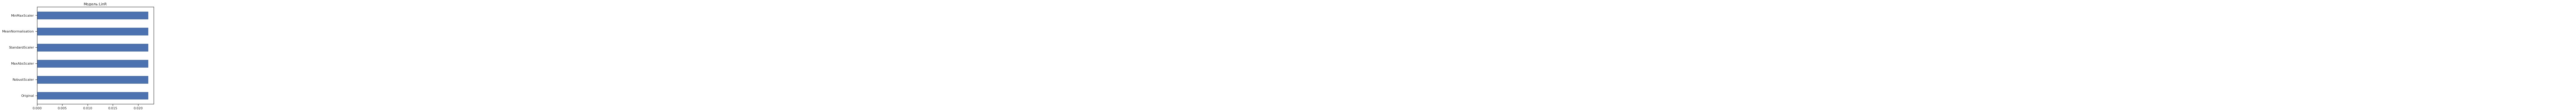

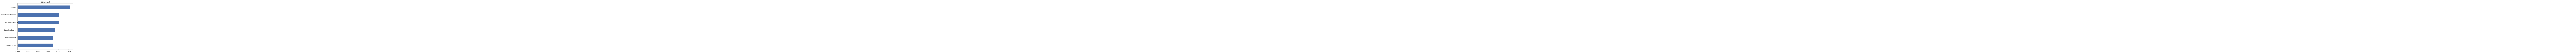

ValueError: ignored

<Figure size 504x432 with 1 Axes>

ValueError: ignored

<Figure size 504x432 with 1 Axes>

ValueError: ignored

<Figure size 504x432 with 1 Axes>

ValueError: ignored

<Figure size 504x432 with 1 Axes>

In [ ]:
# Построим графики метрик качества модели
for model in clas_models_dict:
    logger.plot('Модель:' + model, model, figsize=(7, 6))


Обработка выбросов

In [ ]:
x_col_list = ['Delta', 'Sarosnumber', 'Lunationnumber']

In [ ]:
data_to_scale.shape

(11898, 4)

In [ ]:
def diagnostic_plots(df, variable, title):
    fig, ax = plt.subplots(figsize=(10,7))
    # гистограмма
    plt.subplot(2, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    # ящик с усами
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[variable])    
    # ящик с усами
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[variable])  
    fig.suptitle(title)
    plt.show()

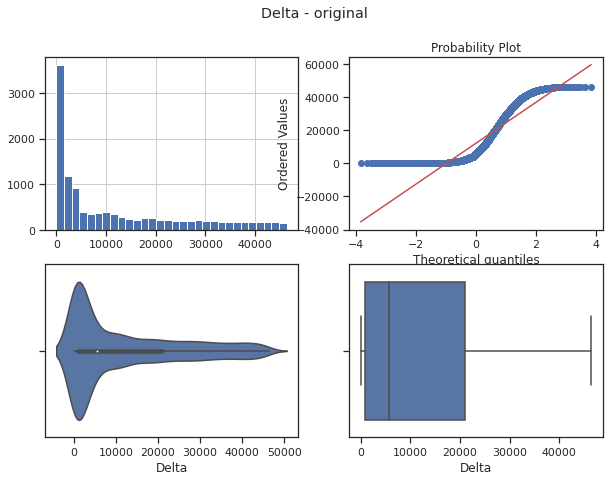

In [ ]:
diagnostic_plots(data_to_scale, 'Delta', 'Delta - original')

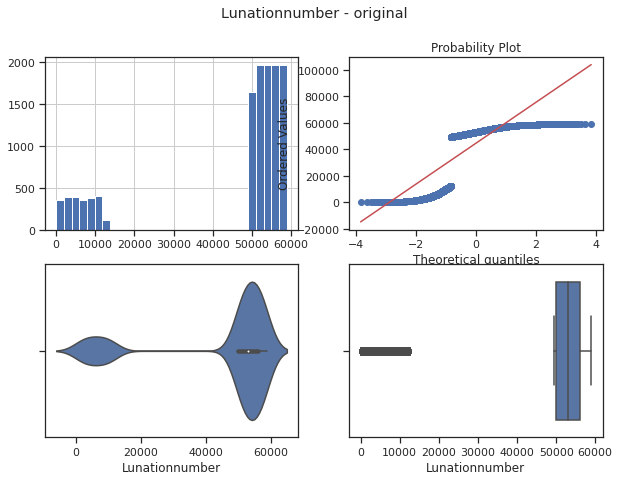

In [ ]:
diagnostic_plots(data_to_scale, 'Lunationnumber', 'Lunationnumber - original')

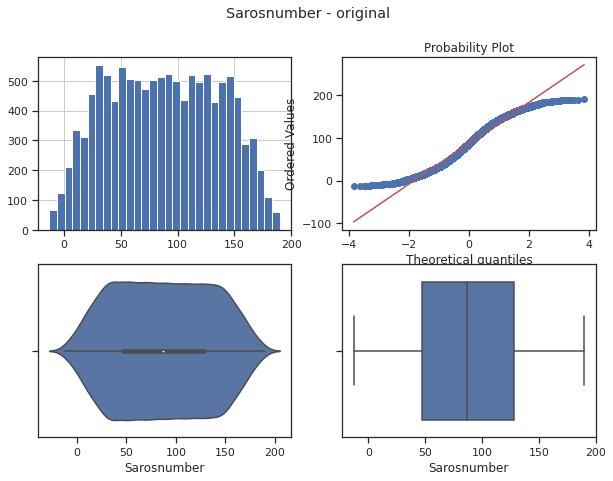

In [ ]:
diagnostic_plots(data_to_scale, 'Sarosnumber', 'Sarosnumber - original')


Обнаружение выбросов

In [ ]:
# Тип вычисления верхней и нижней границы выбросов
from enum import Enum
class OutlierBoundaryType(Enum):
    SIGMA = 1
    QUANTILE = 2
    IRQ = 3


In [ ]:
# Функция вычисления верхней и нижней границы выбросов
def get_outlier_boundaries(df, col, outlier_boundary_type: OutlierBoundaryType):
    if outlier_boundary_type == OutlierBoundaryType.SIGMA:
        K1 = 3
        lower_boundary = df[col].mean() - (K1 * df[col].std())
        upper_boundary = df[col].mean() + (K1 * df[col].std())

    elif outlier_boundary_type == OutlierBoundaryType.QUANTILE:
        lower_boundary = df[col].quantile(0.05)
        upper_boundary = df[col].quantile(0.95)

    elif outlier_boundary_type == OutlierBoundaryType.IRQ:
        K2 = 1.5
        IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
        lower_boundary = df[col].quantile(0.25) - (K2 * IQR)
        upper_boundary = df[col].quantile(0.75) + (K2 * IQR)

    else:
        raise NameError('Unknown Outlier Boundary Type')
        
    return lower_boundary, upper_boundary

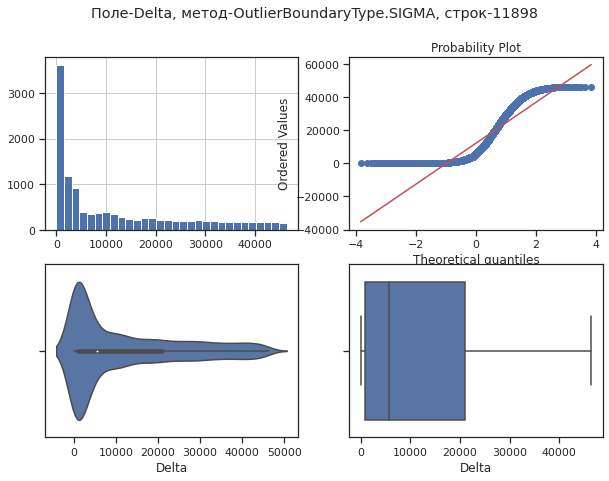

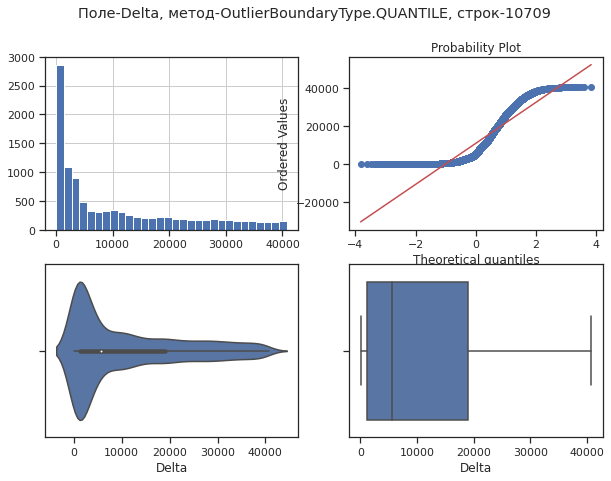

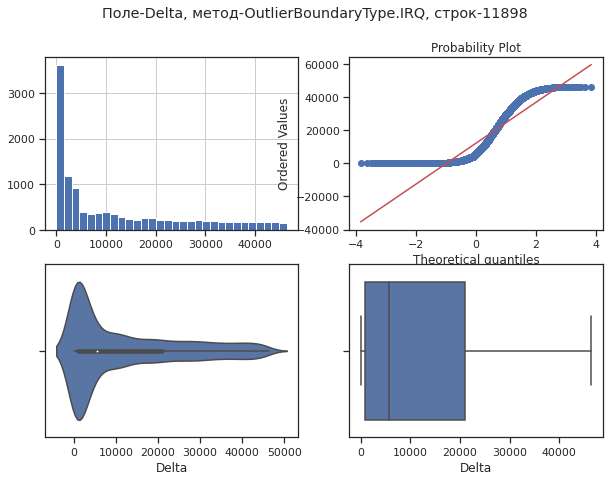

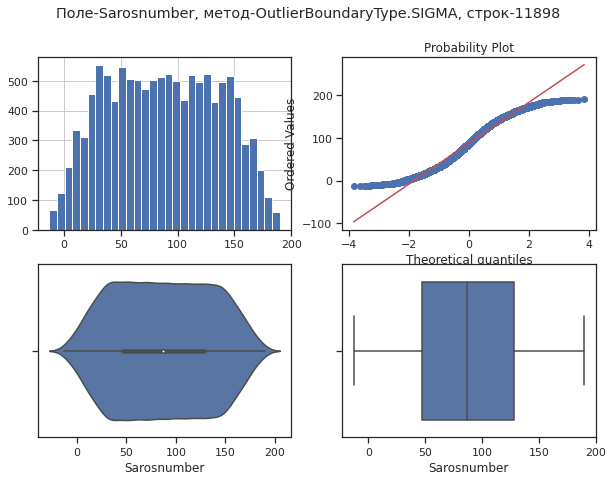

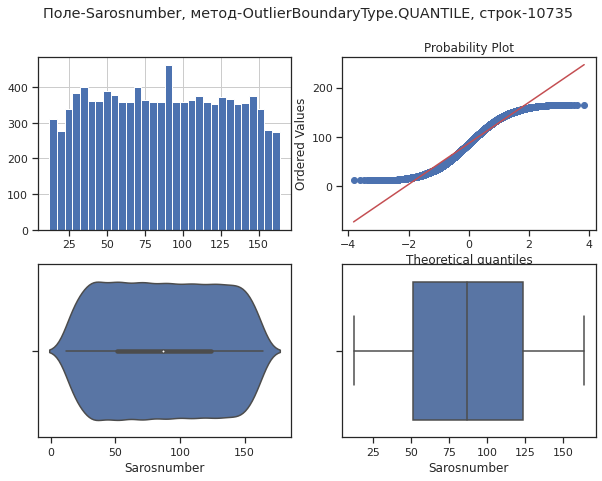

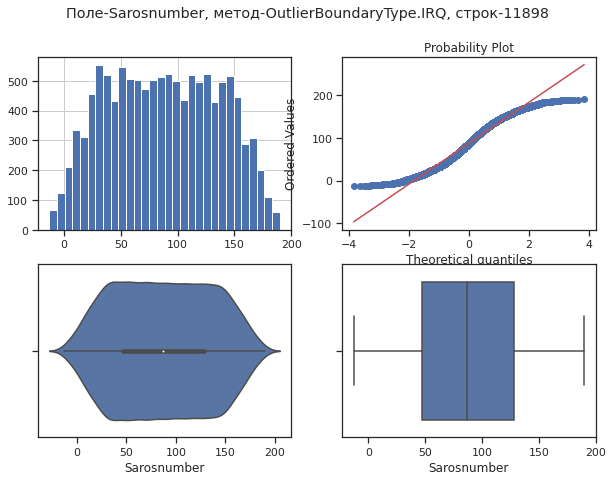

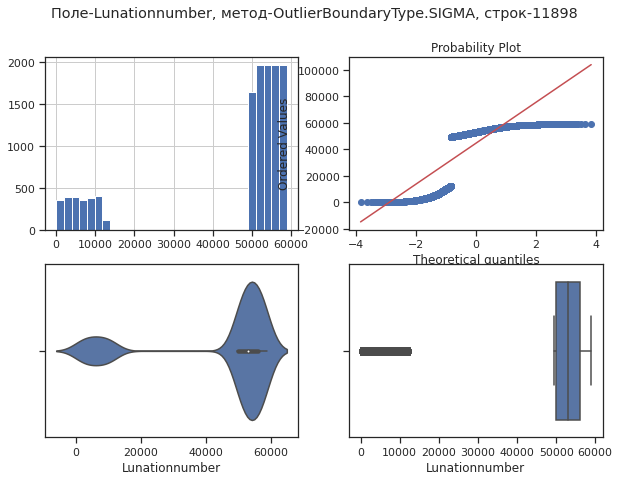

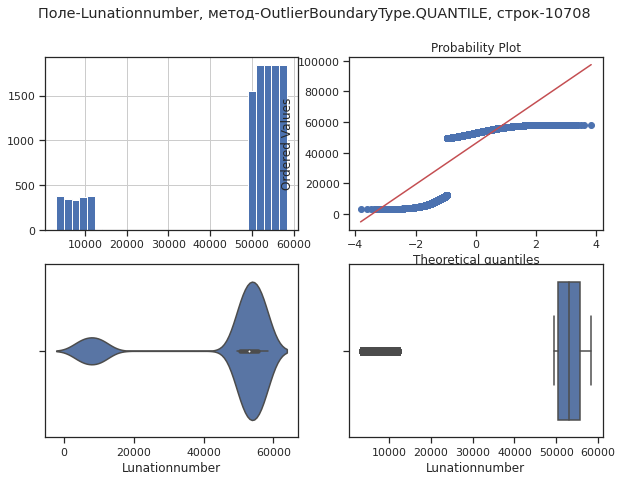

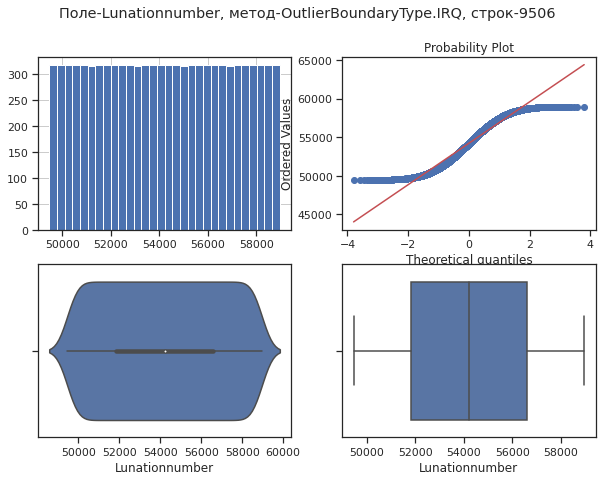

In [ ]:
for col in x_col_list:    
    for obt in OutlierBoundaryType:
        # Вычисление верхней и нижней границы
        lower_boundary, upper_boundary = get_outlier_boundaries(data_to_scale, col, obt)
        # Флаги для удаления выбросов
        outliers_temp = np.where(data_to_scale[col] > upper_boundary, True, 
                                 np.where(data_to_scale[col] < lower_boundary, True, False))
        # Удаление данных на основе флага
        data_trimmed = data_to_scale.loc[~(outliers_temp), ]  
        title = 'Поле-{}, метод-{}, строк-{}'.format(col, obt, data_trimmed.shape[0])
        diagnostic_plots(data_trimmed, col, title)


Замена выбросов

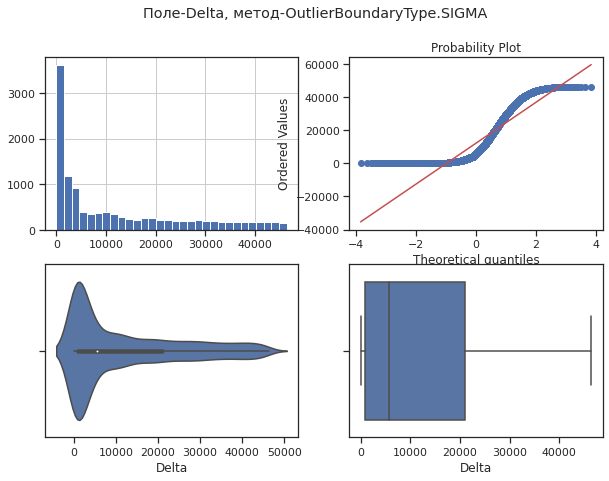

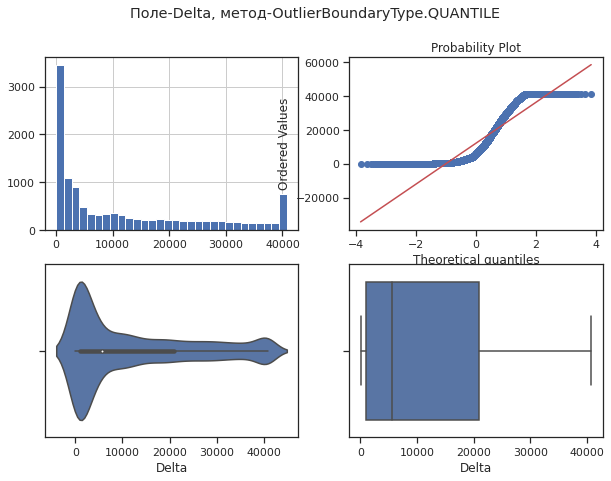

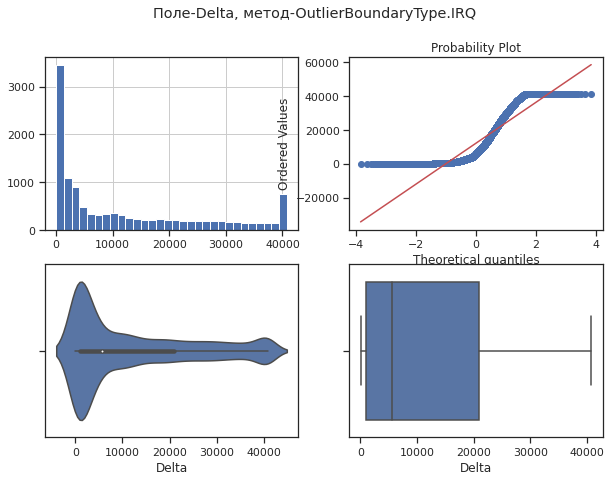

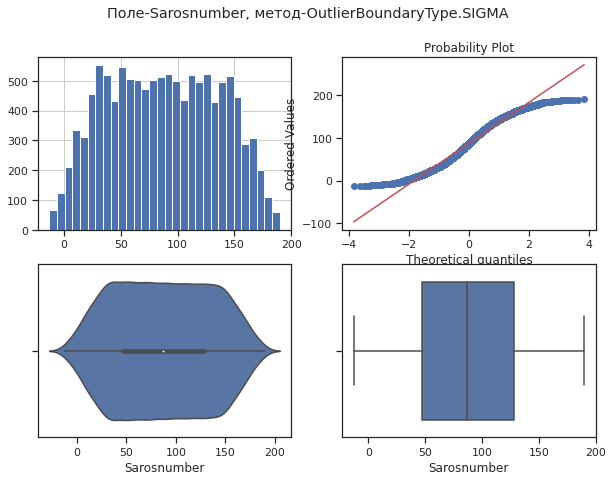

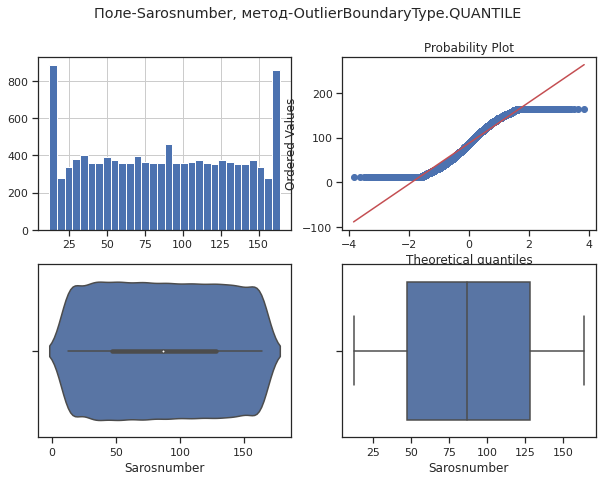

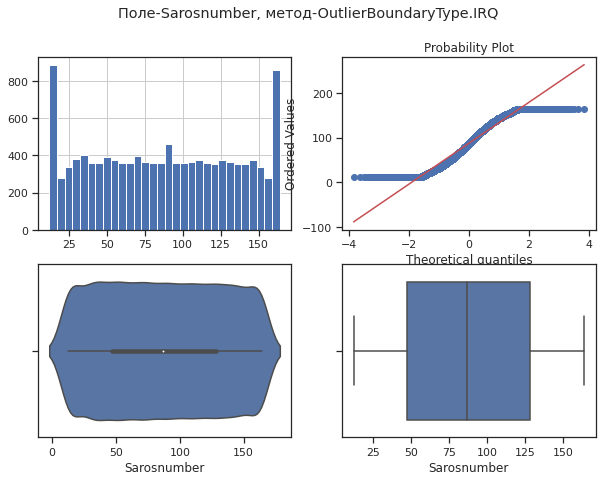

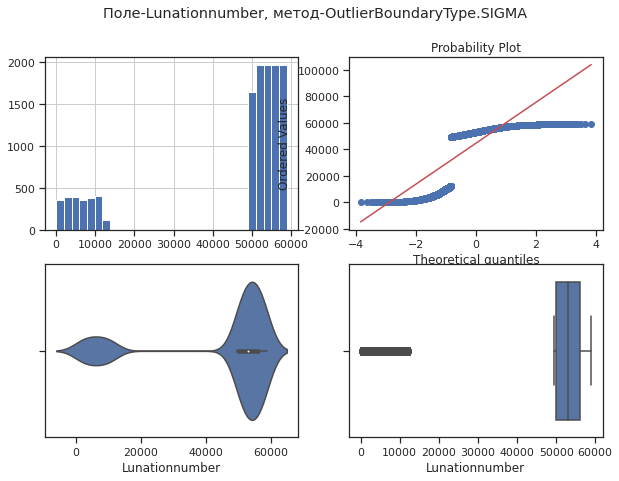

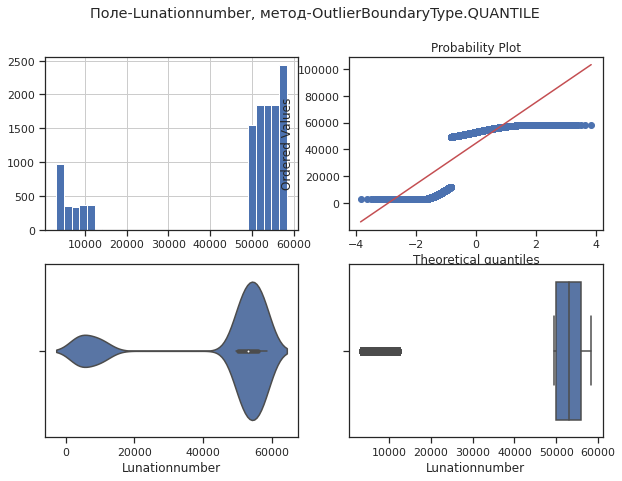

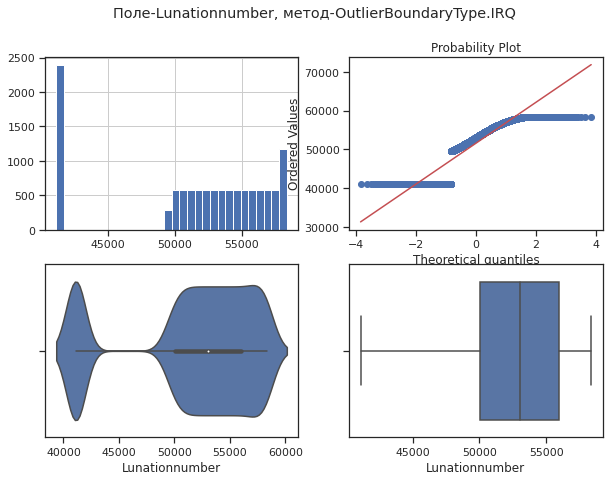

In [ ]:
for col in x_col_list:    
    for obt in OutlierBoundaryType:
        # Вычисление верхней и нижней границы
        lower_boundary, upper_boundary = get_outlier_boundaries(data_to_scale, col, obt)
        # Изменение данных
        data_to_scale[col] = np.where(data_to_scale[col] > upper_boundary, upper_boundary, 
                                 np.where(data_to_scale[col] < lower_boundary, lower_boundary, data_to_scale[col]))
        title = 'Поле-{}, метод-{}'.format(col, obt)
        diagnostic_plots(data_to_scale, col, title)

Отбор признаков
Метод фильтрации
Метод, основынный на корреляции

In [ ]:
cols_to_fs = ['Catalog Number',		'Delta',	'Lunationnumber',	'Sarosnumber',	
              'Sunaltitude','UNIXTime',]
fs_data = data_loaded[cols_to_fs].copy()
fs_data.shape

(32686, 6)

In [ ]:
fs_data_features = list(zip(
[i for i in fs_data.columns],
zip(
    #типы колонок
    [str(i) for i in fs_data.dtypes],
    #проверка, есть ли пропущенные значения
    [i for i in fs_data.isnull().sum()]
)))
fs_data_features

[('Catalog Number', ('float64', 20788)),
 ('Delta', ('float64', 20788)),
 ('Lunationnumber', ('float64', 20788)),
 ('Sarosnumber', ('float64', 20788)),
 ('Sunaltitude', ('float64', 20788)),
 ('UNIXTime', ('int64', 0))]

In [ ]:
fs_data.tail()

,Catalog Number,Delta,Lunationnumber,Sarosnumber,Sunaltitude,UNIXTime
32681,NaN,NaN,NaN,NaN,NaN,1480587604
32682,NaN,NaN,NaN,NaN,NaN,1480587301
32683,NaN,NaN,NaN,NaN,NaN,1480587001
32684,NaN,NaN,NaN,NaN,NaN,1480586702
32685,NaN,NaN,NaN,NaN,NaN,1480586402


In [ ]:
fs_data = fs_data.dropna()
fs_data.shape

(11898, 6)

In [ ]:
g_cat_enc_le = le.fit_transform(fs_data['UNIXTime'])
g_cat_enc_le

array([7416, 7415, 7414, ..., 7419, 7418, 7417])

In [ ]:
fs_data['UNIXTime'] = g_cat_enc_le
fs_data['UNIXTime']

0        7416
1        7415
2        7414
3        7413
4        7412
         ... 
11893    7421
11894    7420
11895    7419
11896    7418
11897    7417
Name: UNIXTime, Length: 11898, dtype: int64

In [ ]:
fs_data

,Catalog Number,Delta,Lunationnumber,Sarosnumber,Sunaltitude,UNIXTime
0,1.0,46438.0,49456.0,5.0,74.0,7416
1,2.0,46426.0,49457.0,10.0,76.0,7415
2,3.0,46415.0,49458.0,15.0,60.0,7414
3,4.0,46403.0,49459.0,20.0,25.0,7413
4,5.0,46393.0,49460.0,-13.0,0.0,7412
...,...,...,...,...,...,...
11893,11894.0,4414.0,12355.0,187.0,0.0,7421
11894,11895.0,4417.0,12360.0,154.0,33.0,7420
11895,11896.0,4420.0,12366.0,159.0,0.0,7419
11896,11897.0,4424.0,12372.0,164.0,82.0,7418


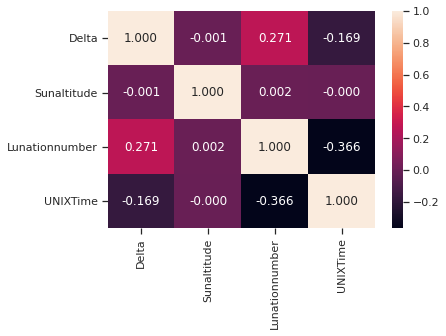

In [ ]:
heatmap_cols = [ 'Delta', 'Sunaltitude', 'Lunationnumber', 'UNIXTime', ]
sns.heatmap(fs_data[heatmap_cols].corr(), annot=True, fmt='.3f')

In [ ]:
# Формирование DataFrame с сильными корреляциями
def make_corr_df(df):
    cr = df.corr() # !!!вот здесь был недочет - data.corr -> df.corr
    cr = cr.abs().unstack() 
    cr = cr.sort_values(ascending=False)
    cr = cr[cr >= 0.3]
    cr = cr[cr < 1]
    cr = pd.DataFrame(cr).reset_index()
    cr.columns = ['f1', 'f2', 'corr']
    return cr

In [ ]:
make_corr_df(fs_data)

,f1,f2,corr
0,Catalog Number,Sarosnumber,0.965515
1,Sarosnumber,Catalog Number,0.965515
2,Catalog Number,Delta,0.896787
3,Delta,Catalog Number,0.896787
4,Sarosnumber,Delta,0.862184
5,Delta,Sarosnumber,0.862184
6,Catalog Number,Lunationnumber,0.588694
7,Lunationnumber,Catalog Number,0.588694
8,Sarosnumber,Lunationnumber,0.572768
9,Lunationnumber,Sarosnumber,0.572768


In [ ]:
# Обнаружение групп коррелирующих признаков
def corr_groups(cr):
    grouped_feature_list = []
    correlated_groups = []

    for feature in cr['f1'].unique():
        if feature not in grouped_feature_list:
            # находим коррелирующие признаки
            correlated_block = cr[cr['f1'] == feature]
            cur_dups = list(correlated_block['f2'].unique()) + [feature]
            grouped_feature_list = grouped_feature_list + cur_dups
            correlated_groups.append(cur_dups)
    return correlated_groups

In [ ]:
# Группы коррелирующих признаков
corr_groups(make_corr_df(fs_data))

[['Sarosnumber', 'Delta', 'Lunationnumber', 'UNIXTime', 'Catalog Number']]


**Метод, основанный на статистических характеристиках**

In [ ]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

In [ ]:
x = fs_data.drop('UNIXTime', axis=1)
x

,Catalog Number,Delta,Lunationnumber,Sarosnumber,Sunaltitude
0,1.0,46438.0,49456.0,5.0,74.0
1,2.0,46426.0,49457.0,10.0,76.0
2,3.0,46415.0,49458.0,15.0,60.0
3,4.0,46403.0,49459.0,20.0,25.0
4,5.0,46393.0,49460.0,-13.0,0.0
...,...,...,...,...,...
11893,11894.0,4414.0,12355.0,187.0,0.0
11894,11895.0,4417.0,12360.0,154.0,33.0
11895,11896.0,4420.0,12366.0,159.0,0.0
11896,11897.0,4424.0,12372.0,164.0,82.0


In [ ]:
y = fs_data['UNIXTime']
y

0        7416
1        7415
2        7414
3        7413
4        7412
         ... 
11893    7421
11894    7420
11895    7419
11896    7418
11897    7417
Name: UNIXTime, Length: 11898, dtype: int64

Text(0, 0.5, 'Взаимная информация')

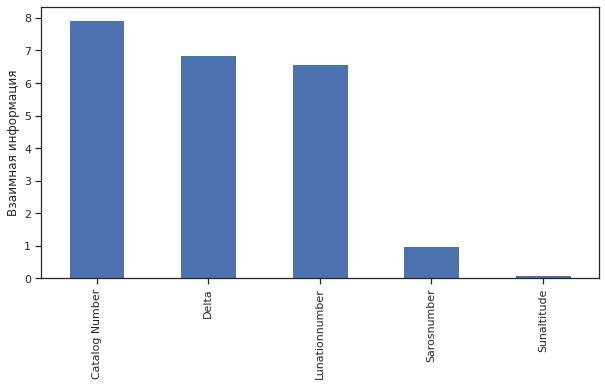

In [ ]:
mi = mutual_info_regression(x, y)
mi = pd.Series(mi)
mi.index = x.columns
mi.sort_values(ascending=False).plot.bar(figsize=(10,5))
plt.ylabel('Взаимная информация')

In [ ]:
sel_mi = SelectKBest(mutual_info_regression, k=5).fit(x, y)

list(zip(x.columns, sel_mi.get_support()))

[('Catalog Number', True),
 ('Delta', True),
 ('Lunationnumber', True),
 ('Sarosnumber', True),
 ('Sunaltitude', True)]